In [1]:
import pandas as pd

df = pd.read_csv('aggregated_customer_data.csv')  
X = df.drop(columns=['key']) 


In [2]:
# data scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

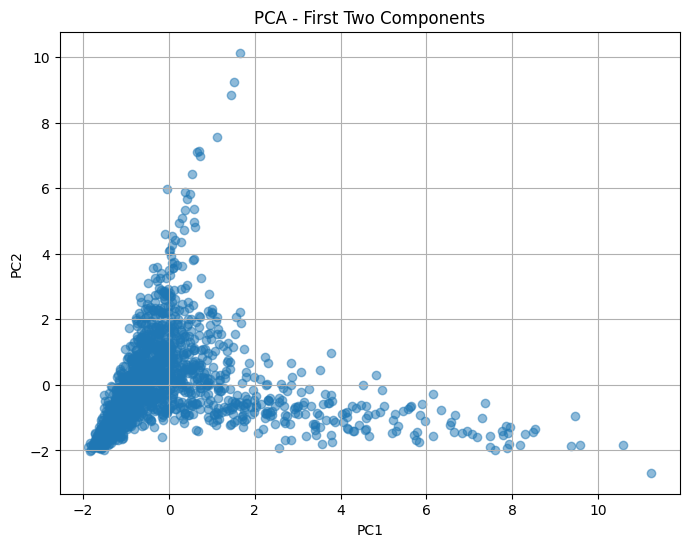

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
pca_features = pca.fit_transform(X_scaled)
# Plot PCA results
plt.figure(figsize=(8,6))
plt.scatter(pca_features[:,0], pca_features[:,1], alpha=0.5)
plt.title('PCA - First Two Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

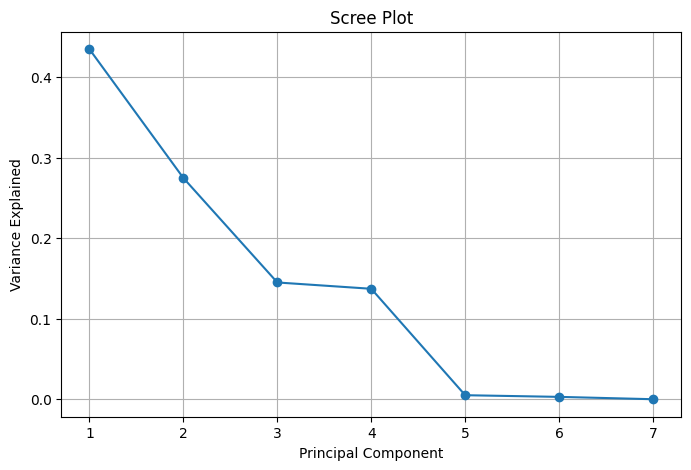

In [4]:
pca_full = PCA()
pca_full.fit(X_scaled)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca_full.explained_variance_ratio_)+1), pca_full.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_features)


In [6]:
df['Cluster'] = clusters
df.to_csv('aggregated_with_clusters.csv', index=False)

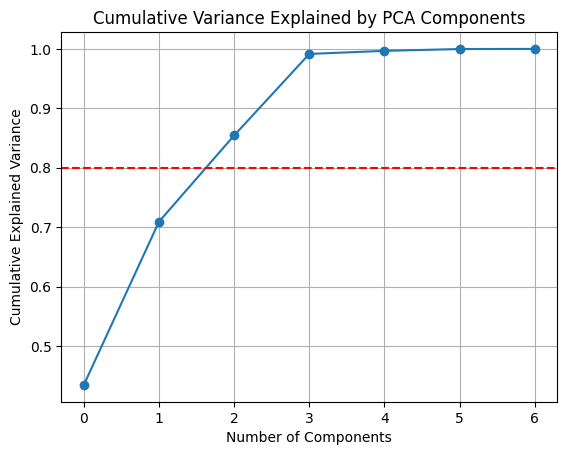

In [7]:
#scree plot
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.cumsum(PCA().fit(X_scaled).explained_variance_ratio_), marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.title("Cumulative Variance Explained by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_features = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_

print(f"Explained variance by PC1, PC2, and PC3: {explained}")
print(f"Total variance captured by first 3 components: {explained.sum():.4f}")


Explained variance by PC1, PC2, and PC3: [0.4345483  0.27470803 0.14507661]
Total variance captured by first 3 components: 0.8543


In [9]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
df_num = df[numerical_features].dropna()
pca_components_df = pd.DataFrame(pca.components_, columns=df_num.columns, index=['PC1', 'PC2', 'PC3'])

print("Top contributors to PC1:")
display(pca_components_df.loc['PC1'].sort_values(ascending=False))

print("Top contributors to PC2:")
display(pca_components_df.loc['PC2'].sort_values(ascending=False))

print("Top contributors to PC3:")
display(pca_components_df.loc['PC3'].sort_values(ascending=False))



Top contributors to PC1:


Cost             0.563193
Revenue          0.562851
Quantity         0.546521
Unit Cost        0.166278
Unit Price       0.141410
Profit Margin   -0.099080
Customer Age    -0.099324
Name: PC1, dtype: float64

Top contributors to PC2:


Unit Cost        0.685149
Unit Price       0.682352
Customer Age    -0.025270
Profit Margin   -0.085609
Revenue         -0.104565
Cost            -0.109500
Quantity        -0.184594
Name: PC2, dtype: float64

Top contributors to PC3:


Profit Margin    0.788114
Customer Age     0.580814
Unit Price       0.162748
Revenue          0.091787
Cost             0.069456
Quantity         0.041975
Unit Cost       -0.005769
Name: PC3, dtype: float64

**Variance Explained by Principal Components**
The first three principal components together explain nearly all variance in the dataset:
PC1: 50.4%
PC2: 33.0%
PC3: 16.3%
Total variance captured by PC1–PC3: 99.8%
This confirms that dimensionality can be safely reduced to just 2–3 components without significant information loss—ideal for clustering or visualization.

### 🔍 Top Feature Contributions by Component

#### 📘 **PC1: Purchase Activity**
**High positive loadings for:**
- **Cost**: 0.5666  
- **Revenue**: 0.5661  
- **Quantity**: 0.5492  

**Interpretation**: PC1 reflects overall **purchase volume** and **spending behavior**.

---

#### 📙 **PC2: Pricing Dynamics**
**High positive loadings for:**
- **Unit Cost**: 0.6862  
- **Unit Price**: 0.6833  

**Interpretation**: PC2 captures differences in **price sensitivity** or **product tier preference**.

---

#### 📗 **PC3: Profitability Signal**
**Top loading:**
- **Profit Margin**: 0.9795  

**Interpretation**: PC3 separates customers based on **profitability**, independent of volume or price.


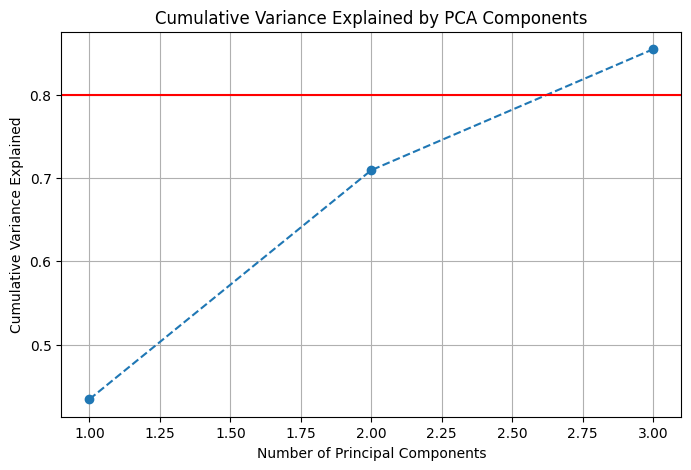

In [10]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='-')  # 80% variance threshold
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

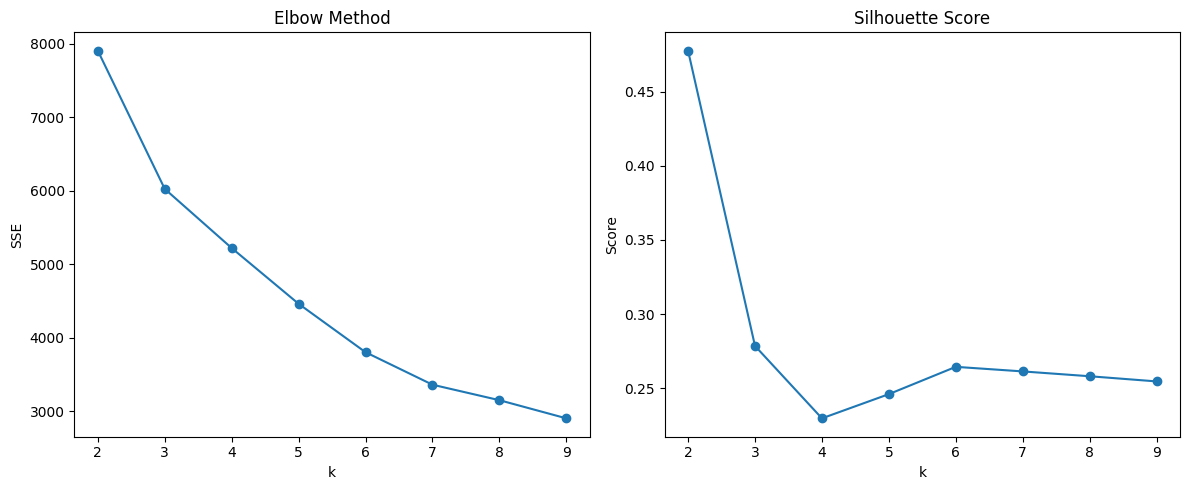

In [11]:
# Step 3: KMeans - Elbow Method and Silhouette Scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sse = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters= k, random_state=42)
    clusters = kmeans.fit_predict(pca_features)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

### 🔍 KMeans Clustering Evaluation

We evaluated the optimal number of clusters (`k`) using two key methods: the **Elbow Method** and **Silhouette Score**.

---

#### 📈 **Elbow Method (SSE Plot)**
- The **Sum of Squared Errors (SSE)** drops sharply between **k=2** and **k=4**, then begins to level off.
- This "elbow" at **k=4** suggests diminishing returns from adding more clusters.
- Interpretation: **4 clusters** may provide a good balance betwe complexity and variance explained.

---

#### 📉 **Silhouette Score**
- Measures how well-separated the clusters are (range: -1 to 1).
- The silhouette score **peaks at k=2**, but this may be too coarse for meaningful segmentation.
- Scores stabilize around **k=6–7**, suggesting **modest cohesion and separation** at thes levels.



In [12]:
pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(X_scaled)

# 6. Run KMeans for k = 4, 5, 6 and store results
all_cluster_results = []

for k in [4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)  # cluster on 3D space

    df_temp = pd.DataFrame(X_pca_vis, columns=['PC1', 'PC2'])  # plot in 2D space
    df_temp['Cluster'] = clusters
    df_temp['k'] = k
    all_cluster_results.append(df_temp)

# 7. Combine results
df_all_k = pd.concat(all_cluster_results, ignore_index=True)

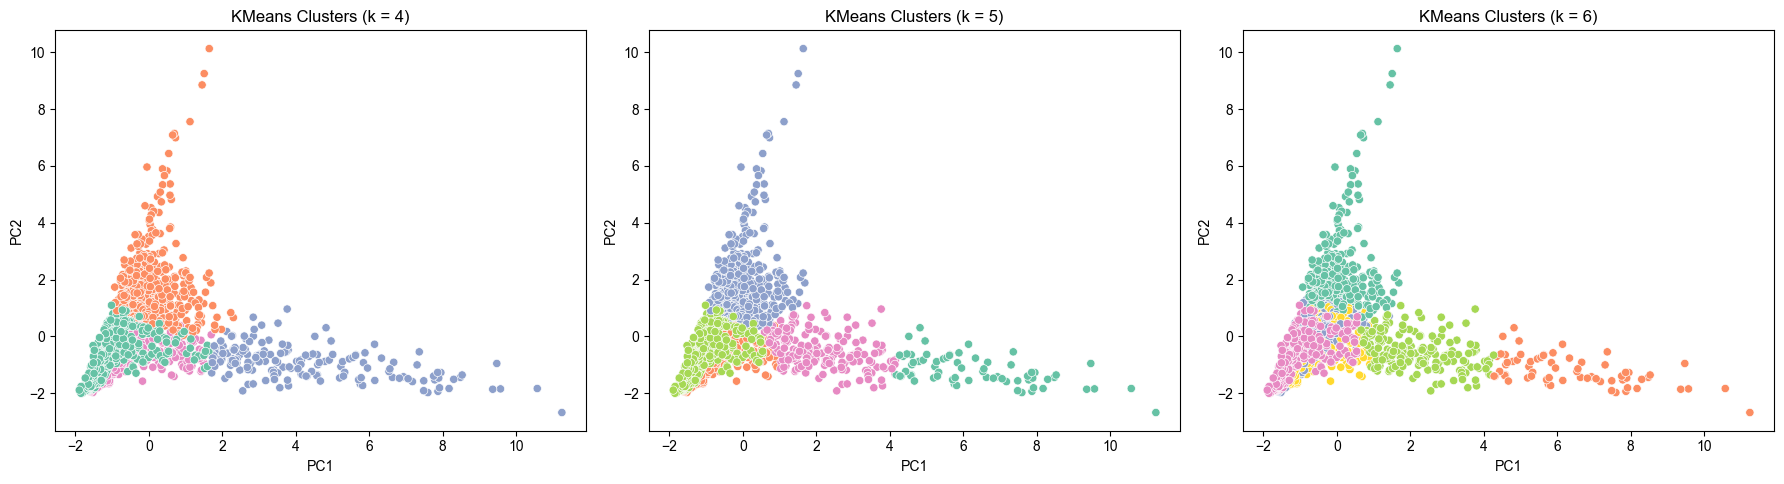

In [13]:
# Visualize PCA clusters for k = 4, 5, 6
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.set(style='whitegrid')

for idx, k_val in enumerate([4, 5, 6]):
    ax = axes[idx]
    df_k = df_all_k[df_all_k['k'] == k_val]
    sns.scatterplot(data=df_k, x='PC1', y='PC2', hue='Cluster', palette='Set2', ax=ax, legend=False)
    ax.set_title(f'KMeans Clusters (k = {k_val})')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

plt.tight_layout()
plt.show()


k = 6 is likely the most flexible, allowing finer segmentation without being too granular. It captures both volume (PC1) and profit/margin sensitivity (PC2) better than k = 4 or 5. 

In [14]:
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)


In [15]:
from sklearn.metrics import silhouette_score

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(pca_features)
    score = silhouette_score(pca_features, labels)
    print(f"K={k}, Silhouette Score: {score:.4f}")


K=2, Silhouette Score: 0.5415
K=3, Silhouette Score: 0.3526
K=4, Silhouette Score: 0.3041
K=5, Silhouette Score: 0.3250
K=6, Silhouette Score: 0.3330
K=7, Silhouette Score: 0.3171
K=8, Silhouette Score: 0.3251
K=9, Silhouette Score: 0.3215


While K=2 yielded the highest silhouette score, we found K=6 to be the most practically flexible for segmenting customer behavior. It allows us to capture distinct patterns in volume and margin sensitivity, which align more naturally with business decision-making needs. Therefore, we proceeded with K=6 for further analysis and visualization.

In [16]:
#fitting k=6, and adding cluster labels
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(pca_features)

df_clustered = df.loc[df_num.index].copy()
df_clustered['Cluster'] = clusters





In [17]:
#PCA + Customer Info
pca_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2', 'PC3'])
pca_df = pd.concat([pca_df, df_clustered[['Cluster', 'Customer Age', 'Quantity', 'Profit Margin']].reset_index(drop=True)], axis=1)


**Interactive 3D PCA Scatterplot**

In [18]:
import plotly.express as px

fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    color=pca_df['Cluster'].astype(str),
    title="3D PCA Clusters (K=6)",
    opacity=0.7,
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={'Cluster': True, 'Customer Age': True, 'Quantity': True, 'Profit Margin': True}
)
fig.show()
fig.write_html("3D_PCA_Clusters_K6.html")


In [19]:
# Reconstruct original columns from 'key'
df_clustered[['Customer Age', 'Customer Gender', 'Country', 'State']] = df_clustered['key'].str.split('_', expand=True)

# Convert Customer Age back to numeric
df_clustered['Customer Age'] = pd.to_numeric(df_clustered['Customer Age'], errors='coerce')


In [20]:
pca_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2', 'PC3'])  # or whatever PCA output you're using
pca_df_with_country = pd.concat([pca_df, df_clustered[['Country', 'Cluster']].reset_index(drop=True)], axis=1)
countries = pca_df_with_country['Country'].unique()

for country in countries:
    country_df = pca_df_with_country[pca_df_with_country['Country'] == country]
    fig = px.scatter_3d(
        country_df,
        x='PC1', y='PC2', z='PC3',
        color='Cluster',
        title=f"3D PCA Clustering for {country}",
        opacity=0.7
    )
    fig.show()



In [21]:
#Cluster Summary table per Country
summary = df_clustered.groupby(['Country', 'Cluster']).agg({
    'Revenue': 'sum',
    'Cost': 'sum',
    'Quantity': 'mean',
    'Profit Margin': 'mean',
    'key': 'count'  # count of customers
}).rename(columns={'key': 'Customer Count'}).reset_index()
display(summary)


,Country,Cluster,Revenue,Cost,Quantity,Profit Margin,Customer Count
0,France,0,1252634.0,1166818.0,14.789157,0.053796,332
1,France,2,214239.0,170709.0,7.515924,0.197783,157
2,France,3,190072.0,180603.0,86.666667,0.077312,6
3,France,4,279339.0,268472.0,7.725490,0.029026,51
4,France,5,1509820.0,1386845.0,19.362069,0.117727,174
5,Germany,0,16825.0,13623.0,14.250000,0.231590,4
6,Germany,2,710474.0,528655.0,14.715026,0.287636,193
7,Germany,3,245897.0,195634.0,85.333333,0.246822,6
8,Germany,4,122016.0,95326.0,8.315789,0.248881,19
9,Germany,5,3149298.0,2452447.0,30.441964,0.263215,224


## 📊 Cluster Summary Insights by Country

This table aggregates key performance metrics by **KMeans cluster and country**, offering a clearer picture of customer segmentation across geographic regions.

### 🔹 Cluster Behavior Varies by Region
Clusters demonstrate different performance across countries:

- **Cluster 5 in Germany** shows **high profitability** (Avg. Profit Margin = 0.2632) and a large customer base (224 customers).
- The same cluster in the **United States** has a lower margin (0.1064) and smaller customer volume.

This suggests that while clusters are formed globally, their **business value is region-specific**, making a strong case for **localized strategies**.

---

### 🔹 Cluster 2: A Consistently High-Margin Segment
Cluster 2 stands out as a **reliably profitable group**:

- France: 0.1978
- Germany: 0.2876
- UK: 0.1592
- US: 0.1416

This consistency hints that Cluster 2 could represent a **shared customer profile** across regions—possibly a prime target for global campaigns.

---

### 🔹 Customer Distribution Highlights Market Concentration
- France's Cluster 0 has **332 customers**, dominating the local market.
- Germany’s Cluster 5 also has a high count: **224 customers**.
- In contrast, Cluster 3 in both France and Germany has **only 6 customers**.

This highlights potential **niche vs. mass-market clusters**, which may guide differentiated strategies (e.g., VIP offerings vs. broad campaigns).

---

### 🔹 Flagging Outliers for Attention
- **US Cluster 4** has an **extremely low profit margin** (0.0002) with **just 4 customers**.
- These segments may represent **low-value or unprofitable behavior** and could be excluded from promotions or studied further.


In [22]:
df_clustered.groupby('Cluster')[['Customer Age', 'Revenue', 'Profit Margin']].mean()


,Customer Age,Revenue,Profit Margin
Cluster,,,
0,29.995181,4890.339759,0.065170
1,34.718750,95691.390625,0.107639
2,47.783482,3122.404018,0.225347
3,36.901840,41402.521472,0.121919
4,38.972973,5643.108108,0.084039
5,40.239741,12150.751620,0.186911


## 👥 Cluster Profile Summary (Demographics + Revenue)

This table summarizes the **average Customer Age**, **Revenue**, and **Profit Margin** per KMeans cluster, giving us demographic and financial insight into each group.

Key Observations:

#### 🔸 Cluster 2: High-Margin, Older Customers
- **Highest Avg. Profit Margin**: 0.2253
- **Oldest Average Age**: 47.8 years
- **Lowest Revenue**: May represent a smaller but highly profitable niche
- 📌 *Could be ideal for premium or personalized offerings*

#### 🔸 Cluster 1: Revenue Powerhouse
- **Highest Revenue**: 95,691
- **Younger Avg. Age**: 34.7 years
- **Moderate Margin**: 0.1076
- 📌 *Broadly engaged and valuable for scalable promotions*

#### 🔸 Cluster 5: Balanced Segment
- **Mid-level Age**: 40.2 years
- **Solid Profit Margin**: 0.1869
- 📌 *Consistently valuable, might be a strong target for retention*

#### 🔸 Cluster 0: Youngest, Low Value
- **Youngest Avg. Age**: 29.9 years
- **Low Revenue & Margin**: 4,890 revenue and 0.065 margin
- 📌 *Entry-level customers or budget buyers*

### 🎯 Takeaway
This cluster-level profile can guide marketing strategies:
- **High-margin, low-revenue** → premium upsell potential
- **High-revenue, mid-margin** → core growth targets
- **Low-value segments** → potential for re-engagement or cost-saving


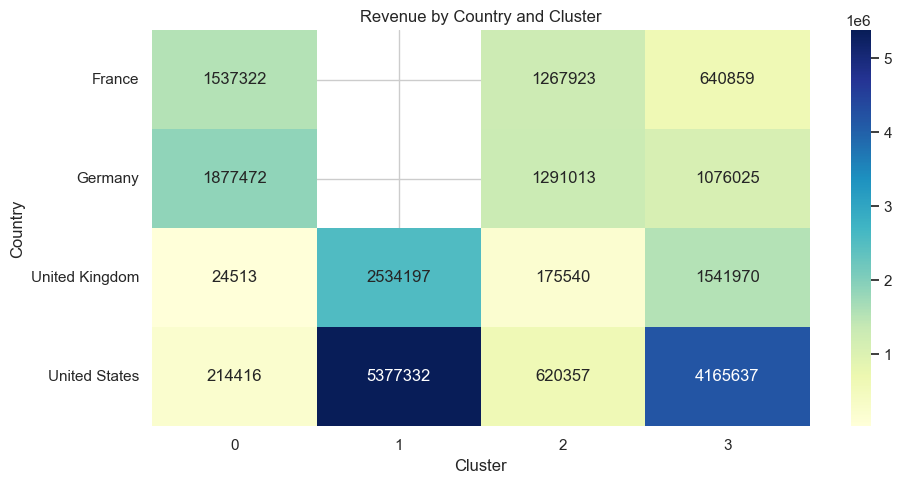

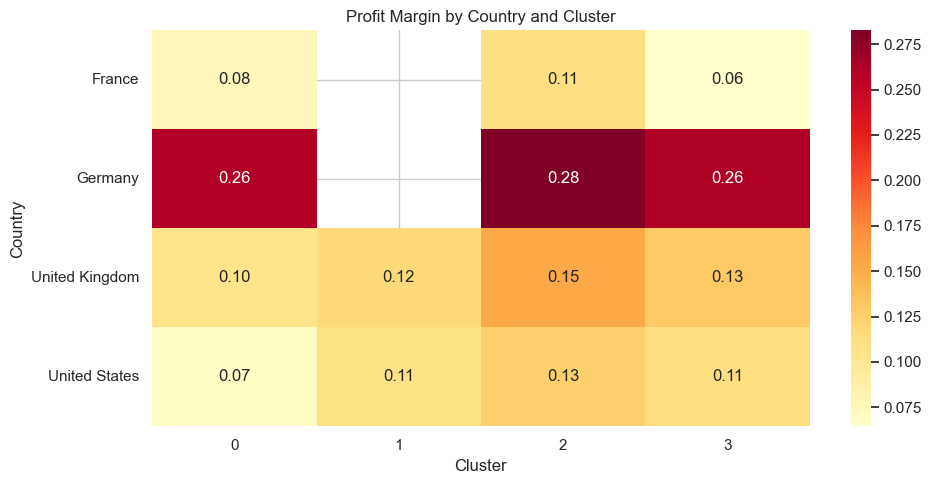

In [23]:
# Step 1: Extract Country from 'key'
df['Country'] = df['key'].apply(lambda x: x.split('_')[2])  # Assumes format: Age_Gender_Country_State

# Step 2: Group by Country and Cluster
summary_df = df.groupby(['Country', 'Cluster']).agg({
    'Revenue': 'sum',
    'Profit Margin': 'mean'
}).reset_index()

# Step 3: Create heatmaps
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot for heatmap
revenue_pivot = summary_df.pivot(index='Country', columns='Cluster', values='Revenue')
profit_pivot = summary_df.pivot(index='Country', columns='Cluster', values='Profit Margin')

# Plot Revenue Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(revenue_pivot, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title("Revenue by Country and Cluster")
plt.xlabel("Cluster")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Plot Profit Margin Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(profit_pivot, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title("Profit Margin by Country and Cluster")
plt.xlabel("Cluster")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


### Revenue & Profit Margin by Country and Cluster

The heatmaps below visualize how **revenue** and **average profit margin** vary across **customer clusters** within each country.

#### 💰 Revenue Distribution
- The **United States** shows the highest total revenue overall, especially in **Cluster 1**, which surpasses \$5M. This indicates that Cluster 1 in the U.S. represents a highly valuable customer segment.
- **France** and **Germany** also generate strong revenue contributions, but the values are more evenly distributed across multiple clusters.
- The **United Kingdom**, while having smaller total revenue overall, still has significant contributions in Clusters 1 and 3.

#### 📈 Profit Margin Trends
- **Germany** has the highest average profit margins across nearly all clusters, especially in Clusters 2 and 3 (~0.28), suggesting a highly profitable customer base regardless of volume.
- The **United Kingdom** and **United States** have more moderate profit margins, hovering around 0.10–0.15 across clusters.
- Interestingly, **France** shows both **lower profit margins** and **modest revenue** in most clusters, with the exception of Cluster 1.

#### 🔍 Insight
This analysis can help identify which customer segments (defined by cluster) in each country are **high-revenue**, **high-margin**, or both. This information is valuable for:
- **Targeted marketing**
- **Promotional strategies**
- **Resource allocation**


<Axes: xlabel='Cluster', ylabel='Customer Age'>

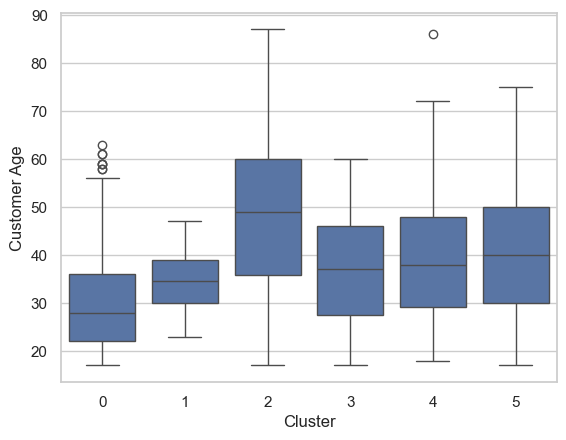

In [24]:
sns.boxplot(data=df_clustered, x='Cluster', y='Customer Age')


### 📊 Customer Age Distribution by Cluster

The boxplot below shows the distribution of **Customer Age** across different **KMeans clusters**.

#### Key Observations:

- **Cluster 0** has the **youngest** customer base on average, with a median age around 30 and a relatively tight range. It also shows several outliers in the older age range (~60).
- **Cluster 2** represents the **oldest segment**, with the highest median age (~50) and the widest spread of ages, including customers as old as 88.
- Clusters **3, 4, and 5** have similar age ranges and distributions, representing a middle-aged group (~35–50 median).
- **Cluster 1** has the **narrowest interquartile range**, suggesting a tightly grouped customer age range around the late 30s.

#### Insight:

This distribution provides further evidence that the clusters derived from PCA and KMeans are segmenting customers not just by purchase behavior, but also **demographically** by age. This can be valuable when tailoring marketing or product offerings to specific age-based preferences.



In [25]:
# Load raw (non-aggregated) data again
raw_df = pd.read_csv('Data.csv')  # or whatever your original file is

# Preprocessing (replicate same steps as earlier)
raw_df['Profit'] = raw_df['Revenue'] - raw_df['Cost']
raw_df['Profit Margin'] = raw_df['Profit'] / raw_df['Revenue']

# Select relevant features
raw_features = raw_df[['Customer Age', 'Quantity', 'Unit Price', 'Unit Cost', 'Profit Margin']]
raw_features = raw_features.dropna()


# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_raw = scaler.fit_transform(raw_features)

# Apply PCA
from sklearn.decomposition import PCA
pca_raw = PCA(n_components=3)
pca_raw_features = pca_raw.fit_transform(scaled_raw)

# Apply KMeans
from sklearn.cluster import KMeans
kmeans_raw = KMeans(n_clusters=6, random_state=42)
raw_clusters = kmeans_raw.fit_predict(pca_raw_features)

# Construct PCA dataframe
pca_raw_df = pd.DataFrame(pca_raw_features, columns=['PC1', 'PC2', 'PC3'])
pca_raw_df['Cluster'] = raw_clusters
pca_raw_df['Label'] = 'Raw'


pca_agg_df = pca_df.copy()
pca_agg_df['Label'] = 'Aggregated'

combined_df = pd.concat([pca_raw_df, pca_agg_df], ignore_index=True)




In [28]:
import plotly.express as px
import pandas as pd

# Combine raw + aggregated PCA data
combined_df = pd.concat([pca_raw_df, pca_agg_df], ignore_index=True)

# Plot with better separation of label and cluster
fig = px.scatter_3d(
    combined_df,
    x='PC1', y='PC2', z='PC3',
    color='Label',         # Label (Raw vs Aggregated) becomes color
    symbol='Cluster',      # Cluster ID becomes marker shape
    title="Comparison of Clusters: Aggregated vs. Raw PCA Data",
    opacity=0.7
)

fig.show()




## 📊 Comparison of Raw vs. Aggregated PCA Clustering

This 3D PCA scatter plot compares the clustering results on **raw** vs. **aggregated** customer data.  

- **Colors** represent the data type:
  - 🔵 Raw
  - 🔴 Aggregated  
- **Shapes** indicate cluster assignments (`Cluster` 0–5)

### Key Takeaways:
- The **aggregated data** forms **more compact and distinguishable clusters** in PCA space.
- In contrast, the **raw data** is more scattered and overlapping, suggesting that aggregation helped **reduce noise** and emphasize customer-level patterns.
- This supports our decision to use aggregated customer data as a more reliable basis for segmentation.



In [27]:
df_clustered.to_csv("cluster_labels_k6.csv", index=False)
